## Our goal is to find a good strategy to invest in S&P500 index (also known as ^GPSC).

Our benchmarks are Buy and Hold strategy and KISS (Keep It Simple, Stupid) method. The latter consists in investing when the today price is greater or equal to the 1-year moving average and selling when the today price is less than the 1-year moving average.

We improve KISS method considering linear combinations of moving averages and moving standard deviations over different periods of time. We first consider the gross yield and then the net one. The net yield considers a 0.10% tax to the broker at each transaction and a 26% tax on capital gain (as it is by the Italian law).

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import fix_yahoo_finance
import quandl
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.optimize import basinhopping
from scipy.optimize import brute
import seaborn as sns

In [2]:
start_date_train=datetime.datetime(1998, 1, 1)
end_date_train=datetime.datetime(2004, 12, 31)
start_date_test=datetime.datetime(2005, 1, 1)
end_date_test=datetime.datetime(2019, 1, 29)

In [3]:
gspc_train = pdr.get_data_yahoo('^GSPC', start=start_date_train, end=end_date_train)
gspc_test = pdr.get_data_yahoo('^GSPC', start=start_date_test, end=end_date_test)

In [4]:
gspc_train.drop(["Adj Close","High","Low","Close","Volume"],axis=1,inplace=True)
gspc_test.drop(["Adj Close","High","Low","Close","Volume"],axis=1,inplace=True)

In [5]:
gspc_train["mvavg_30"]=gspc_train["Open"].rolling(window=30).mean().fillna(0)
gspc_train["mvavg_120"]=gspc_train["Open"].rolling(window=120).mean().fillna(0)
gspc_train["mvavg_252"]=gspc_train["Open"].rolling(window=252).mean().fillna(0)
gspc_train["mvstd_252"]=gspc_train["Open"].rolling(window=252).std().fillna(0)
gspc_train["mvavg_450"]=gspc_train["Open"].rolling(window=450).mean().fillna(0)
gspc_train["mvstd_450"]=gspc_train["Open"].rolling(window=450).std().fillna(0)

gspc_test["mvavg_30"]=gspc_test["Open"].rolling(window=30).mean().fillna(0)
gspc_test["mvavg_120"]=gspc_test["Open"].rolling(window=120).mean().fillna(0)
gspc_test["mvavg_252"]=gspc_test["Open"].rolling(window=252).mean().fillna(0)
gspc_test["mvstd_252"]=gspc_test["Open"].rolling(window=252).std().fillna(0)
gspc_test["mvavg_450"]=gspc_test["Open"].rolling(window=450).mean().fillna(0)
gspc_test["mvstd_450"]=gspc_test["Open"].rolling(window=450).std().fillna(0)

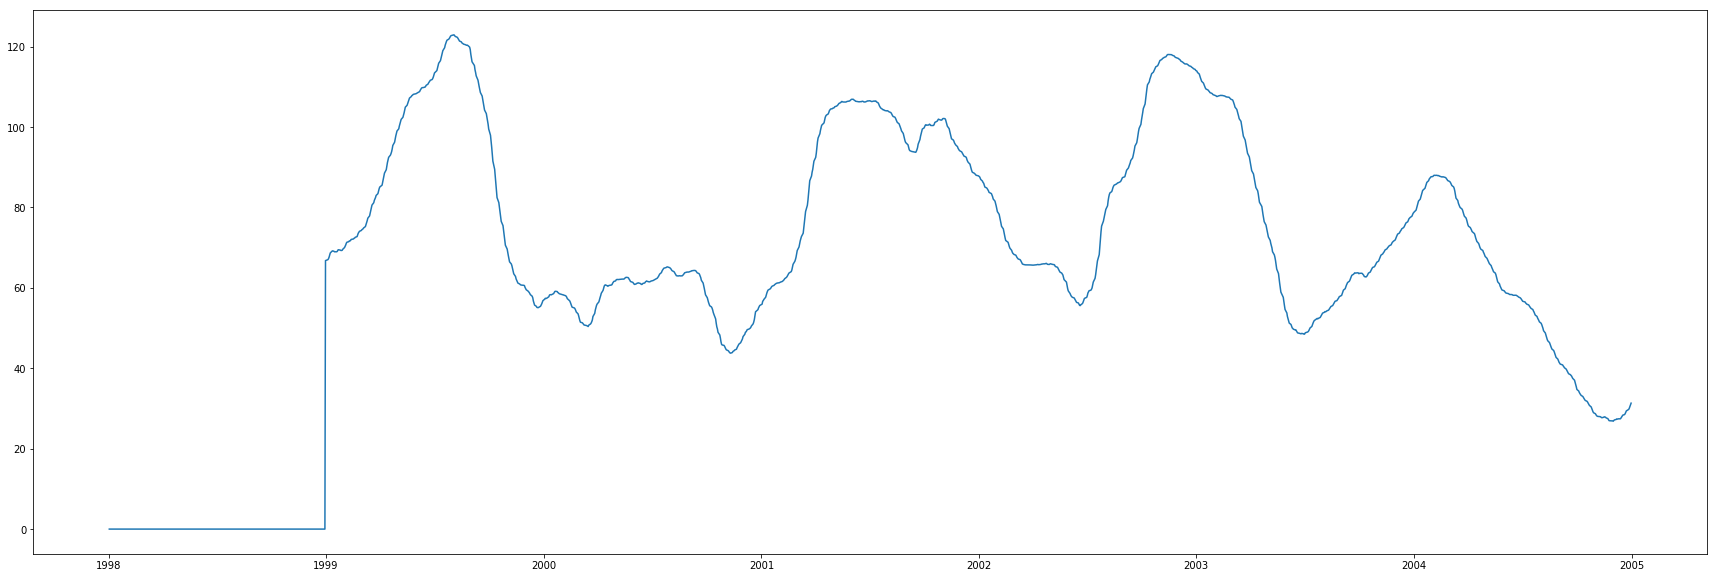

In [6]:
plt.figure(figsize=(30,10))
plt.plot(gspc_train["mvstd_252"])
plt.show()

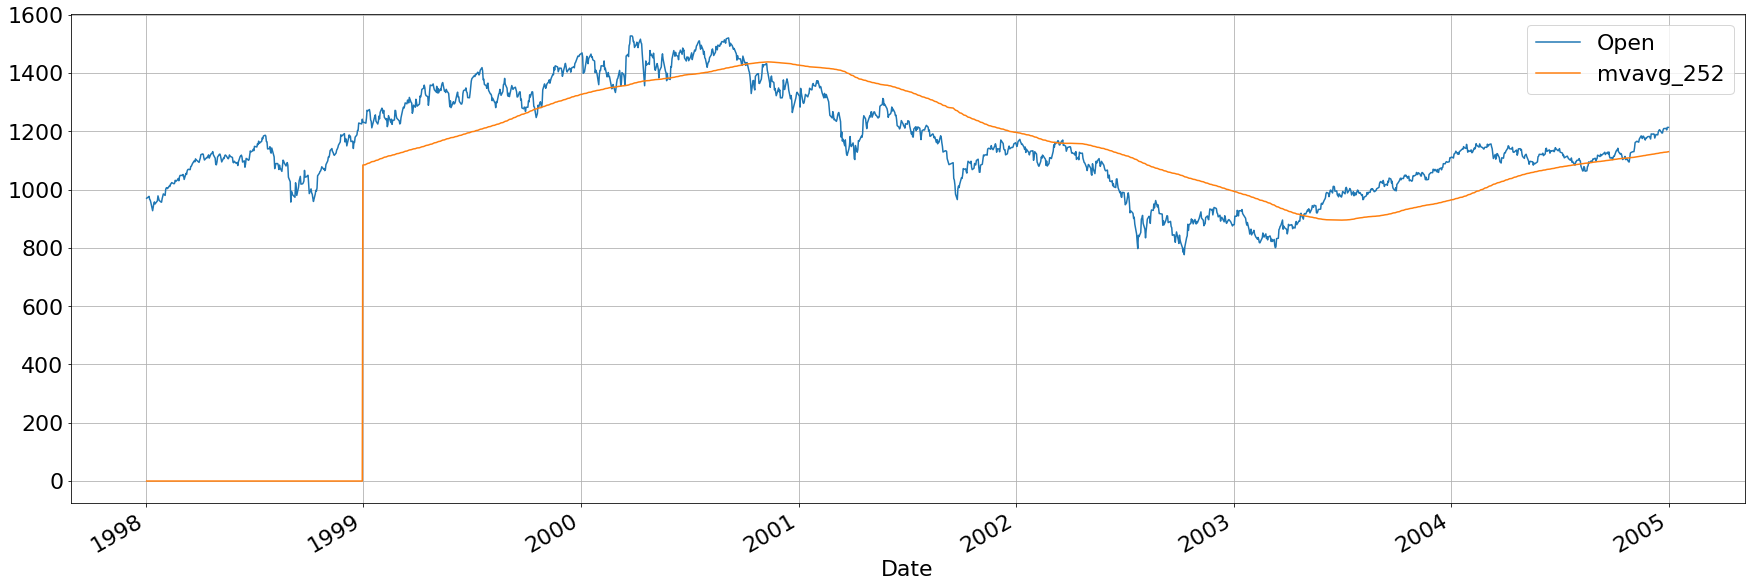

In [7]:
plt.rcParams.update({'font.size': 22})
gspc_train[["Open","mvavg_252"]].plot(figsize=(30,10),grid=True)

In [8]:
gspc_train["rapp"]=(gspc_train["Open"].divide(gspc_train["Open"].shift(1))).shift(-1).fillna(1)
gspc_test["rapp"]=(gspc_test["Open"].divide(gspc_test["Open"].shift(1))).shift(-1).fillna(1)

gspc_train["rapp"][:252]=1
gspc_test["rapp"][:252]=1

In [9]:
gspc_train.head()

,Open,mvavg_30,mvavg_120,mvavg_252,mvstd_252,mvavg_450,mvstd_450,rapp
Date,,,,,,,,
1998-01-02,970.429993,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1998-01-05,975.039978,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1998-01-06,977.070007,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1998-01-07,966.580017,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1998-01-08,964.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### We develop two functions to compute the gross yield: "yield_prod" (the fastest) and "check". We control that the two functions produce the same yield.

### We define the "compute_coeffs" function to compute the optimal coefficients of the linear combination of moving averages at 252 and 30 days to maximize yield (using yield_prod) using brute force method

In [10]:
def lin_comb(df,a):
    lin_comb=df["Open"]+a[0]*df[v1]+a[1]*df[v2]
    return lin_comb

def yield_prod(df,a):
    line_comb=lin_comb(df,a)
    v=np.maximum(0,np.sign(np.array(line_comb.values)))
    return (v*df["rapp"]+(1-v)).prod()
    

def min_yield(df,a):
    line_comb=lin_comb(df,a)
    v=np.maximum(0,np.sign(np.array(line_comb.values)))
    window= np.ones(200)
    
    to_min=[(df["rapp"].fillna(1)*v+(1-v))[i:i+200].prod() for i in range(0,df.shape[0]-200,30)]
    u=np.amin(to_min)
    
    
    return u


def compute_coeffs():
    
    def to_minimize(a):
        return -yield_prod(gspc_train,a)#-min_yield(gspc_train,a)
        
    ranges = (slice(-2, 0, 0.01),slice(-2, 0, 0.01),)

    resbrute = brute(to_minimize,ranges)
    
    return resbrute



In [11]:
def check(df,coeffs):
    
    line_comb=lin_comb(df,coeffs)
    df["signals"]=((line_comb).apply(np.sign)+1)/2
    df["bos"]=df["signals"].diff()
    
    df["portfolio_gross"]=df["Open"][0]
    df["shares"]=1
    df.index=range(df.shape[0])
    for ind in range(252,df.shape[0]):
        if df.loc[ind,"signals"]==0.0:
            if df.loc[ind,"bos"]==-1.0:
                # Sell
                df.loc[ind,"shares"]=0
                df.loc[ind,"portfolio_gross"]=df.loc[ind-1,"shares"]*df.loc[ind,"Open"]
                #df.loc[ind,"portfolio_gross"]=df.loc[ind-1,"portfolio_gross"]
            if df.loc[ind,"bos"]==0.0:
                # Keep out
                df.loc[ind,"portfolio_gross"]=df.loc[ind-1,"portfolio_gross"]
                df.loc[ind,"shares"]=0
        if df.loc[ind,"signals"]==1.0:
            if df.loc[ind,"bos"]==0.0:
                # Keep in 
                df.loc[ind,"shares"]=df.loc[ind-1,"shares"]
                df.loc[ind,"portfolio_gross"]=df.loc[ind,"shares"]*df.loc[ind,"Open"]
            if df.loc[ind,"bos"]==1.0:
                # Buy
                df.loc[ind,"portfolio_gross"]=df.loc[ind-1,"portfolio_gross"]
                df.loc[ind,"shares"]=df.loc[ind,"portfolio_gross"]/df.loc[ind,"Open"]
                #df.loc[ind,"shares"]=df.loc[ind-1,"portfolio_gross"]/df.loc[ind-1,"Open"]
                #df.loc[ind,"portfolio_gross"]=df.loc[ind,"shares"]*df.loc[ind,"Open"]
    return round(df["portfolio_gross"][df.index[-1]]/df["portfolio_gross"][252],8)

In [12]:
v1="mvavg_252"
v2="mvavg_30"

for i in np.arange(-3,0,1)/10:
    for j in np.arange(-3,0,1)/10:
        print i,j
        print round(yield_prod(gspc_train,[i,j]),5)==round(check(gspc_train,[i,j]),5)
        print round(yield_prod(gspc_train,[i,j]),5)
        print "\n"

-0.3 -0.3
True
0.98724


-0.3 -0.2
True
0.98724


-0.3 -0.1
True
0.98724


-0.2 -0.3
True
0.98724


-0.2 -0.2
True
0.98724


-0.2 -0.1
True
0.98724


-0.1 -0.3
True
0.98724


-0.1 -0.2
True
0.98724


-0.1 -0.1
True
0.98724




In [13]:
v1="mvavg_252"
v2="mvavg_30"
start=time.time()
coeffs= compute_coeffs()

print "Optimal coefficients: ",coeffs
print "Computed yield: ",yield_prod(gspc_train,coeffs)
print "Verified yield: ",check(gspc_train,coeffs)
print "Minutes of computation: ",(time.time()-start)/60

Optimal coefficients:  [-0.854625 -0.123375]
Computed yield:  1.4341306881243745
Verified yield:  1.43413069
Minutes of computation:  1.24030789932


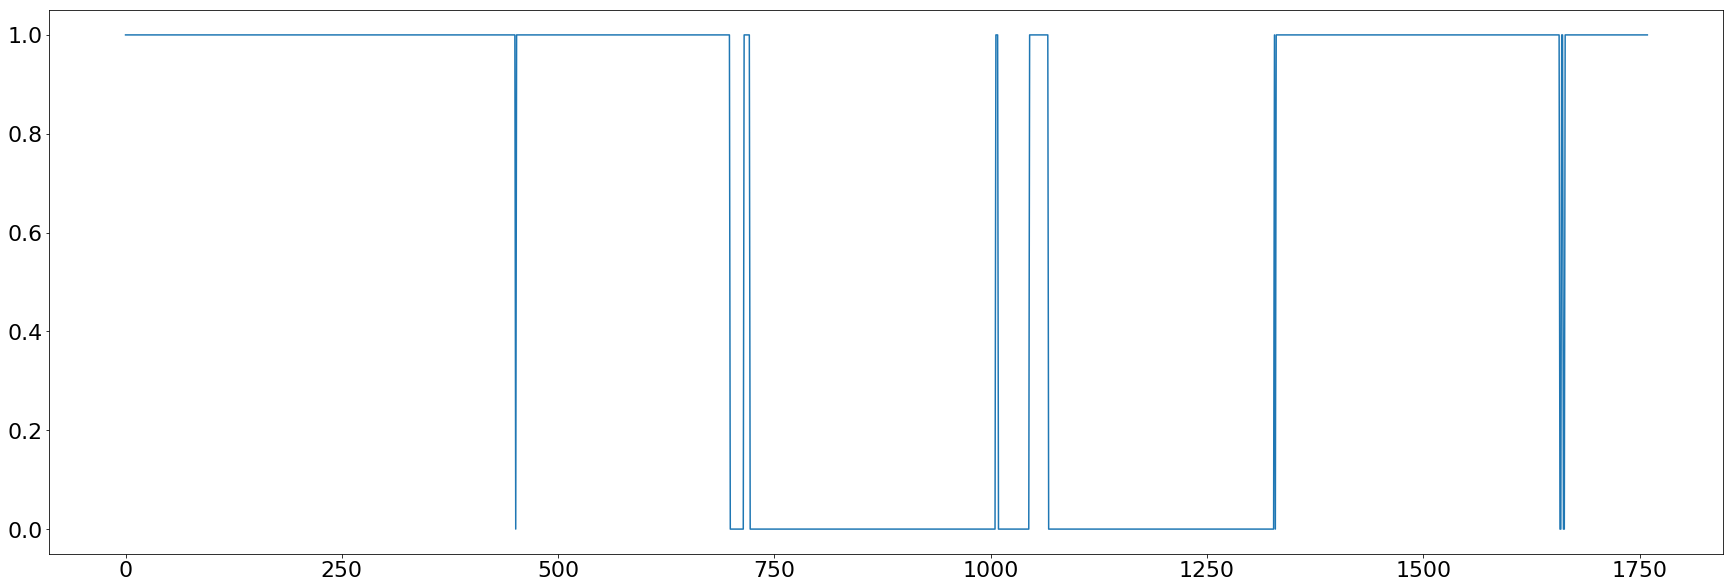

In [14]:
gspc_train["signals"].plot(figsize=(30,10))

### We can now visualize the buy and sell instants and the growth of the portfolio

In [15]:
def visualize(df):
    
    #line_comb=lin_comb(df,coeffs)
    #df["signals"]=((line_comb).apply(np.sign)+1)/2
    #df["bos"]=df["signals"].diff()
    
    plt.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize=(30,10))

    ax1 = fig.add_subplot(111)

    df[["Open","mvavg_252"]].plot(ax=ax1,grid=True,lw=0.5)
    plt.plot(-lin_comb(df,coeffs)+df["Open"])
        # Plot the buy signals
    ax1.scatter(df.loc[df.bos == 1.0].index, df.Open[df.bos == 1.0],marker='^',color="b",s=50.0)

        # Plot the sell signals
    ax1.scatter(df.loc[df.bos == -1.0].index, df.Open[df.bos == -1.0],marker='v',color="r",s=50.0)

    plt.show()

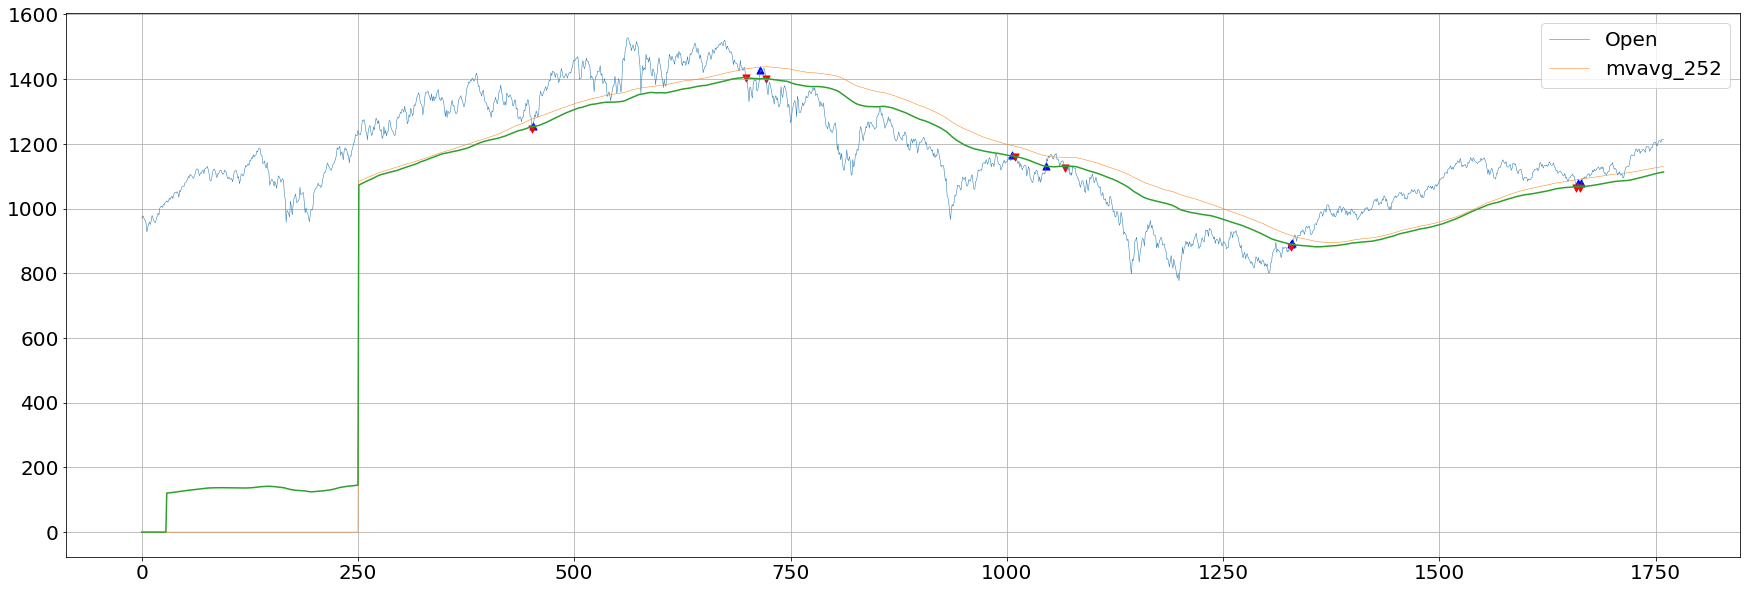

In [16]:
visualize(gspc_train)

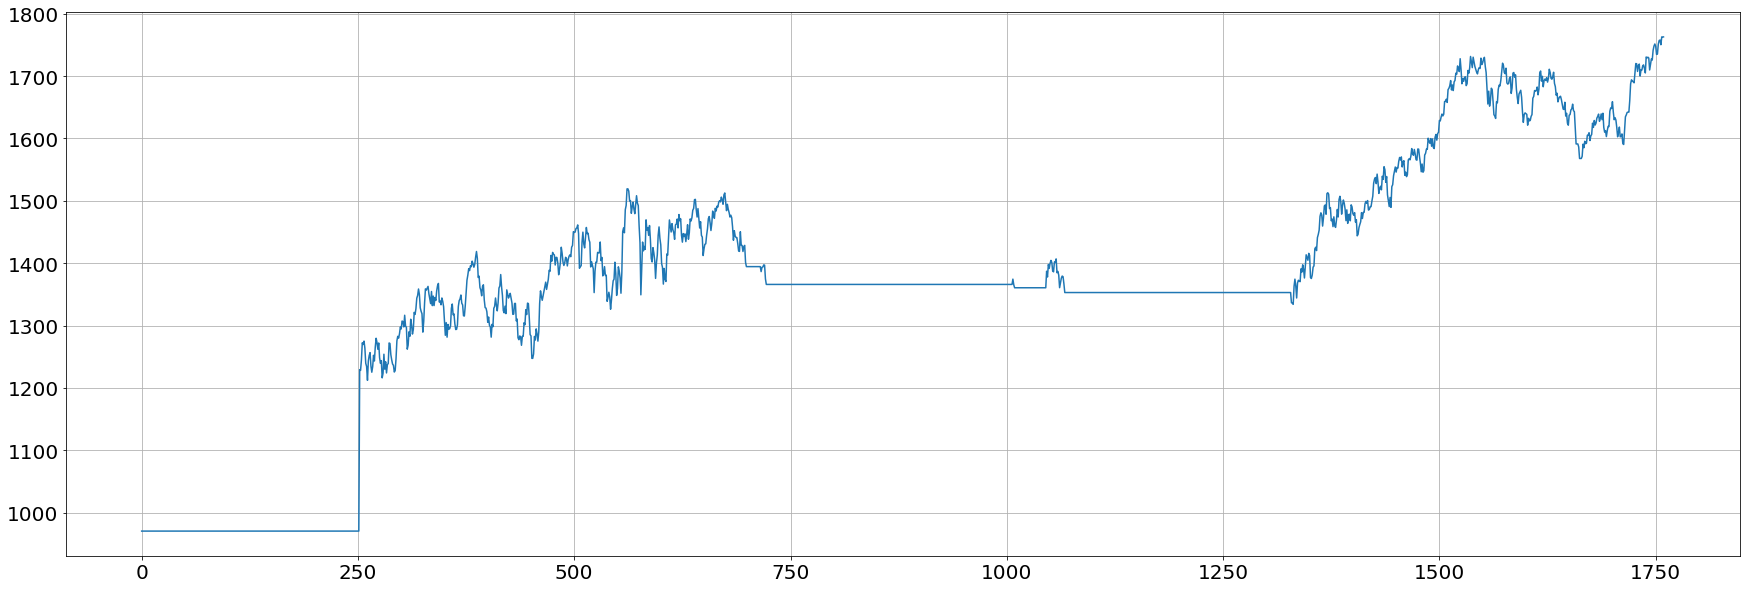

In [17]:
gspc_train["portfolio_gross"].plot(figsize=(30,10),grid=True)

### Finally we compare the three methods on the test set

In [18]:
def compare(df):
    
    print "Yield B&H= ",round(yield_prod(gspc_test,np.ones(2)),4)
    print "Yield KISS= ",round(yield_prod(gspc_test,[-1,0]),4)
    
    print "Yield custom method= ",round(yield_prod(gspc_test,coeffs),4)
    print "Verified yield custom method= ",round(check(gspc_test,coeffs),4)
    

Yield B&H=  2.1188
Yield KISS=  1.9943
Yield custom method=  2.2956
Verified yield custom method=  2.2956


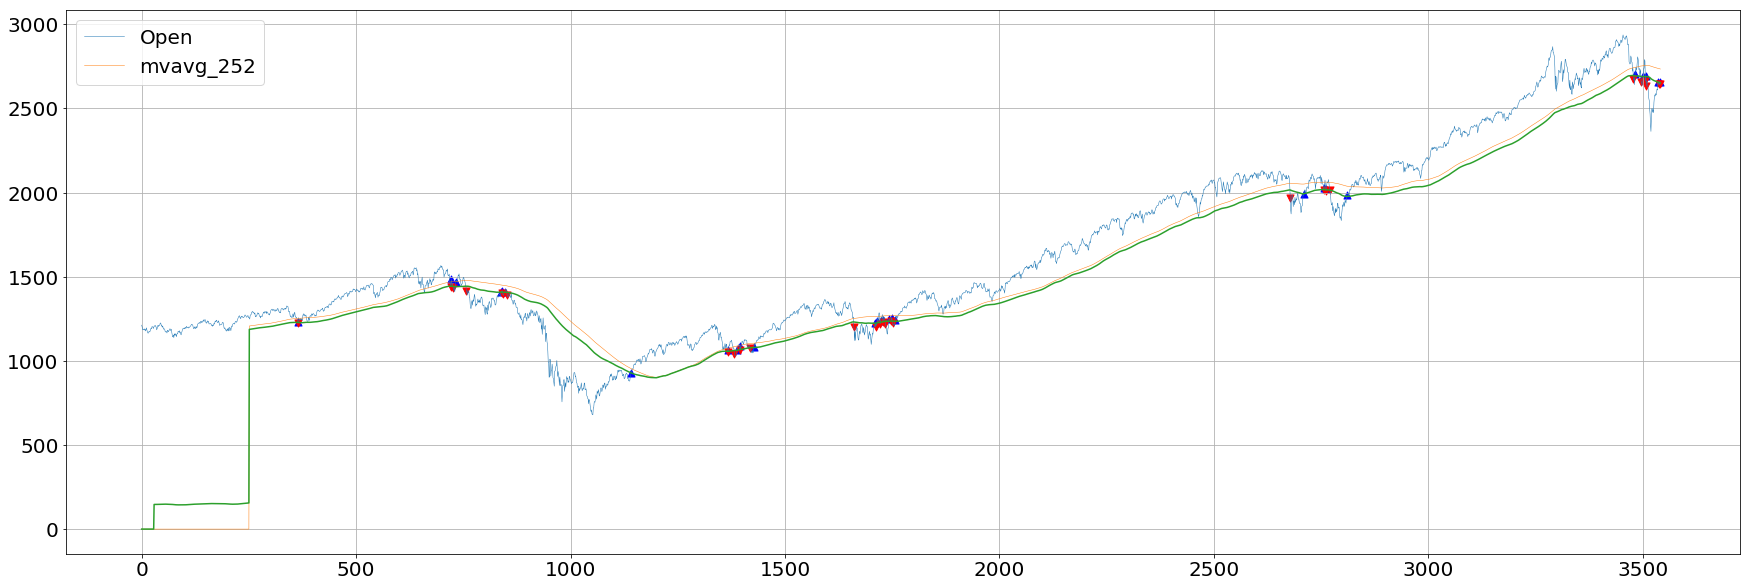

In [19]:
compare(gspc_test)
visualize(gspc_test)

----------------------------------------------------------------------------------------------------------------

### Now we start the analysis of the net yield (considering a 0.10% commission on transaction and a 26% tax on capital gain).

### As before, we compute the yield with two methods: yield_prod_net (the fastest) and check_net

In [20]:
def expand_islands2D(v):
    # Get start, stop of 1s islands
    v1 = np.r_[0,v,0]
    idx = np.flatnonzero(v1[:-1] != v1[1:])
    s0,s1 = idx[::2],idx[1::2]
    if len(s0)==0:
        return np.zeros(len(v)),0
    
    # Initialize 1D id array  of size same as expected o/p and has 
    # starts and stops assigned as 1s and -1s, so that a final cumsum
    # gives us the desired o/p
    N,M = len(s0),len(v)
    out = np.zeros(N*M,dtype=int)

    # Setup starts with 1s
    r = np.arange(N)*M
    out[s0+r] = 1


    # Setup stops with -1s
    if s1[-1] == M:
        out[s1[:-1]+r[:-1]] = -1
    else:
        out[s1+r] -= 1

    # Final cumsum on ID array
    out2D = out.cumsum().reshape(N,-1)
    return out2D,N

In [21]:
def yield_prod_net(df,a):
    
    line_comb=lin_comb(df,a)
    v=np.maximum(0,np.sign(np.array(line_comb.values)))
    w,n=expand_islands2D(v)
    A=(w*np.array(df["rapp"])+(1-w)).prod(axis=1)
    #print v*df["rapp"]
    out=(np.sign(np.sign(1-A)+1)*A+0.74*np.maximum(0,np.sign(A-1))*A+0.26*np.maximum(0,np.sign(A-1)))
    return out.prod()*(0.999**(2*n))
    

def compute_coeffs_net():
    
    def to_minimize_net(a):
        return -yield_prod_net(gspc_train,a)#-min_yield(gspc_train,a)
        
    ranges = (slice(-2, 0, 0.01),slice(-2, 0, 0.01),)

    resbrute = brute(to_minimize_net,ranges)
    
    return resbrute

In [22]:
def check_net(df,a):
    
    line_comb=lin_comb(df,a)
    df["signalsn"]=((line_comb).apply(np.sign)+1)/2
    df["bosn"]=df["signalsn"].diff()
    
    df["portfolio_net"]=df["Open"][252]
    df["shares_net"]=1
    df["plus0"]=0
    df.loc[:253,"plus0"]=df.loc[252,"Open"]
    #df[["signalsn","bosn"]].plot()
    for ind in range(252,df.shape[0]):
        if df.loc[ind,"signalsn"]==0.0:
            if df.loc[ind,"bosn"]==-1.0:
                # Vendo
                df.loc[ind,"shares_net"]=0
                if df.loc[ind,"Open"]*df.loc[ind-1,"shares_net"]>df.loc[ind-1,"plus0"]:
                    df.loc[ind,"portfolio_net"]=(((df.loc[ind-1,"shares_net"]*df.loc[ind,"Open"])
                                                    -df.loc[ind-1,"plus0"])*0.74+df.loc[ind-1,"plus0"])*0.999
                if df.loc[ind,"Open"]*df.loc[ind-1,"shares_net"]<=df.loc[ind-1,"plus0"]:
                    df.loc[ind,"portfolio_net"]=df.loc[ind,"Open"]*df.loc[ind-1,"shares_net"]*0.999
            if df.loc[ind,"bosn"]==0.0:
                # Rimango fuori
                df.loc[ind,"portfolio_net"]=df.loc[ind-1,"portfolio_net"]
                df.loc[ind,"shares_net"]=0
        if df.loc[ind,"signalsn"]==1.0:
            if df.loc[ind,"bosn"]==0.0:
                # Mi mantengo dentro
                df.loc[ind,"shares_net"]=df.loc[ind-1,"shares_net"]
                df.loc[ind,"portfolio_net"]=df.loc[ind,"shares_net"]*df.loc[ind,"Open"]
                df.loc[ind,"plus0"]=df.loc[ind-1,"plus0"]
            if df.loc[ind,"bosn"]==1.0:
                # Compro
                df.loc[ind,"portfolio_net"]=df.loc[ind-1,"portfolio_net"]*0.999
                df.loc[ind,"shares_net"]=df.loc[ind,"portfolio_net"]/df.loc[ind,"Open"]
                df.loc[ind,"plus0"]=df.loc[ind,"portfolio_net"]
    
    
    if df.loc[df.index[-1],"signalsn"]==0:            
        return df["portfolio_net"][df.index[-1]]/df["portfolio_net"][252]
    if df.loc[df.index[-1],"signalsn"]==1: 
        #print df.loc[df.index[-1]-5:df.index[-1],["Open","portforlio_kiss_net","signalsn","bosn"]]
        #print df["portfolio_net"][-5:-1]
        #print df.loc[df.index[-1],"portfolio_net"]
        if df.loc[df.index[-1],"portfolio_net"]>df.loc[df.index[-1],"plus0"]:
            return ((((df.loc[df.index[-1]-1,"shares_net"]*df.loc[df.index[-1],"Open"])\
                      -df.loc[df.index[-1]-1,"plus0"])*0.74+df.loc[df.index[-1]-1,"plus0"])*0.999**2)\
        /df["portfolio_net"][0]
        if df.loc[df.index[-1],"portfolio_net"]<=df.loc[df.index[-1],"plus0"]:
            return (df.loc[df.index[-1],"portfolio_net"]/df.loc[252,"portfolio_net"])*0.999**2

### We check if the two functions give the same yield

In [23]:
print round(yield_prod_net(gspc_train,[1,1]),4)
print round(check_net(gspc_train,[1,1]),4)
print "\n"
print round(yield_prod_net(gspc_train,[-1,0]),4)
print round(check_net(gspc_train,[-1,0]),4)
print "\n"
print round(yield_prod_net(gspc_train,[0,-0.8]),4)
print round(check_net(gspc_train,[0,-0.8]),4)

print "\n"
print round(yield_prod_net(gspc_train,[-0.5,-0.6]),4)
print round(check_net(gspc_train,[-0.5,-0.6]),4)
print "\n"
print round(yield_prod_net(gspc_train,[-0.7,-0.2]),4)
print round(check_net(gspc_train,[-0.7,-0.2]),4)

0.9853
0.9853


1.0452
1.0452


0.9853
0.9853


0.9695
0.9714


0.78
0.78


### We now compute the optimal coefficients for the moving averages at 252 and 30 days to maximize the net yield. Interestingly, these are the same coefficients which maximize the gross yield. We also use a heatmap to show how the net yield depends on the coefficients

In [24]:
v1="mvavg_252"
v2="mvavg_30"
start=time.time()
coeffsn= compute_coeffs_net()

print "Optimal coefficients: ",coeffsn
print "Computed yield: ",yield_prod_net(gspc_train,coeffsn)
print "Verified yield: ",check_net(gspc_train,coeffsn)
print "Minutes of computation: ",(time.time()-start)/60

Optimal coefficients:  [-0.854625 -0.123375]
Computed yield:  1.2702803921128794
Verified yield:  1.270280392112881
Minutes of computation:  0.987601415316


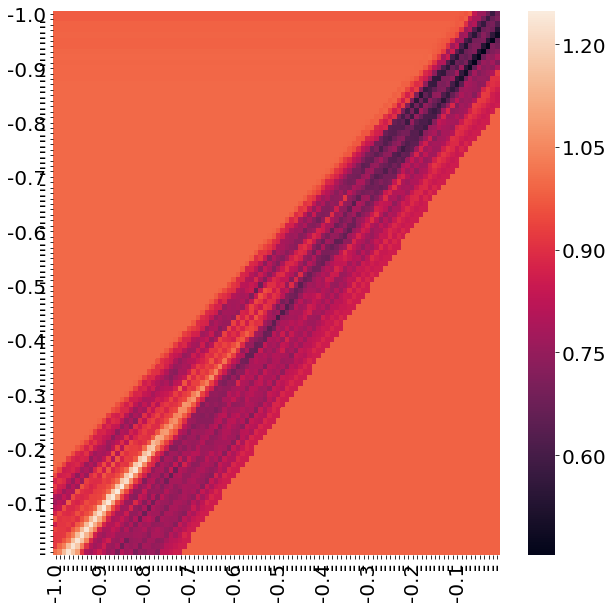

In [25]:
x=np.arange(-1,0,0.01)
y=[[yield_prod_net(gspc_train,[i,j])for i in x]for j in x]
xa=[round(x1,2) for x1 in x]
xp=[]
for i in range(100):
    xp.append("-")
xp[::10]=xa[::10]
plt.figure(figsize=(10,10))
sns.heatmap(y,xticklabels=xp,yticklabels=xp)
plt.show()


### We now compute the couple of moving averages or moving standard deviations which gives the best net yield on the train set

In [26]:
names=["mvavg_30","mvavg_120","mvavg_252","mvavg_450","mvstd_252","mvstd_450"]

prova=[]
for i in range(len(names)):
    for j in range(len(names)):
        if [j,i] not in prova:
            if i!=j:
                prova.append([i,j])
print len(prova)

15


In [27]:
results=[]
for x in prova:
    v1=names[x[0]]
    v2=names[x[1]]
    print v1,v2
    st=time.time()
    coeffsn= compute_coeffs_net()
    print "Optimal coefficients: ",coeffsn
    print "Yield: ",yield_prod_net(gspc_train,coeffsn)
    print "Minutes of computation: ",(time.time()-st)/60
    results.append([v1,v2,yield_prod_net(gspc_train,coeffsn),coeffsn])
    print "\n"

mvavg_30 mvavg_120
Optimal coefficients:  [-0.05 -0.99]
Yield:  1.0080471553439294
Minutes of computation:  0.873554432392


mvavg_30 mvavg_252
Optimal coefficients:  [-0.13365625 -0.8446875 ]
Yield:  1.2702803921128794
Minutes of computation:  0.982664616903


mvavg_30 mvavg_450
Optimal coefficients:  [-0.10725 -0.93   ]
Yield:  1.2244076773620307
Minutes of computation:  0.985239883264


mvavg_30 mvstd_252
Optimal coefficients:  [-0.96 -2.  ]
Yield:  1.0286658792468846
Minutes of computation:  1.02998344898


mvavg_30 mvstd_450
Optimal coefficients:  [-0.9370625 -2.053125 ]
Yield:  1.0256624966426955
Minutes of computation:  1.02496255239


mvavg_120 mvavg_252
Optimal coefficients:  [-0.16 -0.82]
Yield:  1.2851815647631448
Minutes of computation:  0.946248384317


mvavg_120 mvavg_450
Optimal coefficients:  [-0.41 -0.59]
Yield:  1.307443364514747
Minutes of computation:  0.945643115044


mvavg_120 mvstd_252
Optimal coefficients:  [-0.91 -1.65]
Yield:  1.0962482403524885
Minutes of com

In [36]:
results=pd.DataFrame(results)

results.to_csv("results",sep=',')

best=results.loc[results[2].idxmax()]
coeffsn=best[3]
v1=best[0]
v2=best[1]
print "Best net yield =", round(best[2],2), " obtained with ", best[0], " and ",best[1]
print "Verified best net yield = ",round(check_net(gspc_train,coeffsn),2)

Best net yield = 1.33  obtained with  mvavg_252  and  mvavg_450
Verified best net yield =  1.33


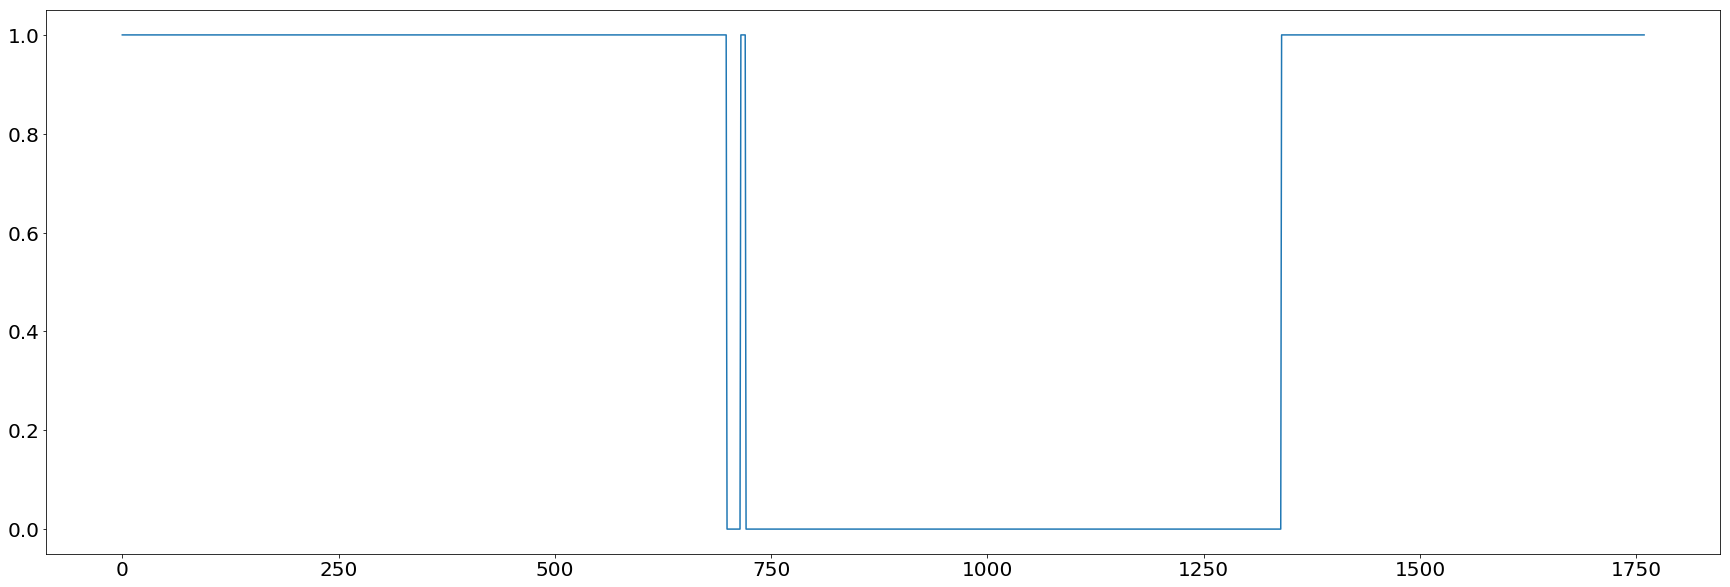

In [37]:
gspc_train["signalsn"].plot(figsize=(30,10))

In [38]:
def visualizen(df):
    
    #line_comb=lin_comb(df,coeffs)
    #df["signals"]=((line_comb).apply(np.sign)+1)/2
    #df["bos"]=df["signals"].diff()
    
    plt.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize=(30,10))

    ax1 = fig.add_subplot(111)

    df[["Open","mvavg_252"]].plot(ax=ax1,grid=True,lw=0.5)
    plt.plot(-lin_comb(df,coeffsn)+df["Open"])
        # Plot the buy signals
    ax1.scatter(df.loc[df.bosn == 1.0].index, df.Open[df.bosn == 1.0],marker='^',color="b",s=50.0)

        # Plot the sell signals
    ax1.scatter(df.loc[df.bosn == -1.0].index, df.Open[df.bosn == -1.0],marker='v',color="r",s=50.0)

    plt.show()

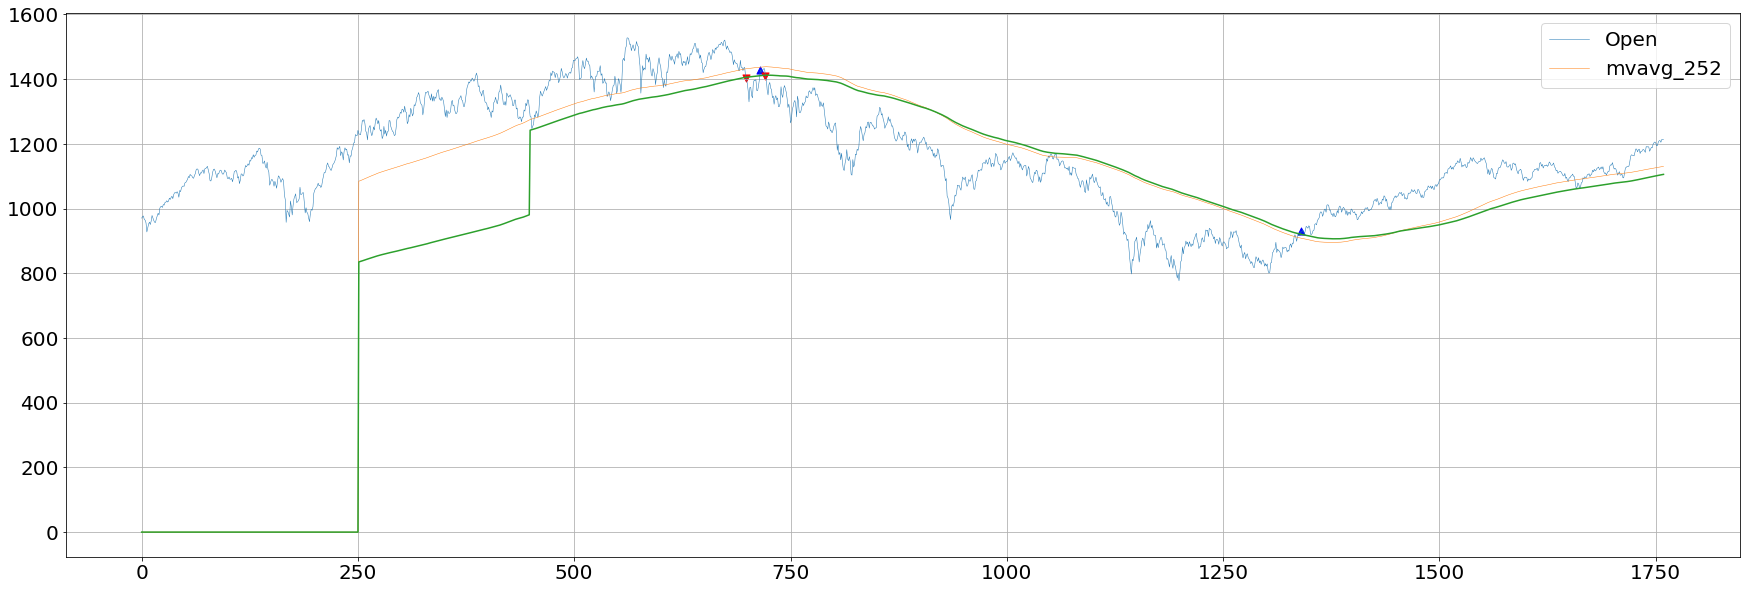

In [39]:
visualizen(gspc_train)

### Now we check how well the net optimized method performed on the test set

In [40]:
def comparen(df):
    
    print "Net yield B&H= ",round(yield_prod_net(gspc_test,np.ones(2)),2)
    print "Net yield KISS= ",round(yield_prod_net(gspc_test,[-1,0]),2)
    print "Net yield custom method= ",round(yield_prod_net(gspc_test,coeffsn),2)
    print "Verified net yield custom method= ",round(check_net(gspc_test,coeffsn),2)

Net yield B&H=  1.82
Net yield KISS=  1.44
Net yield custom method=  1.66
Verified net yield custom method=  1.66


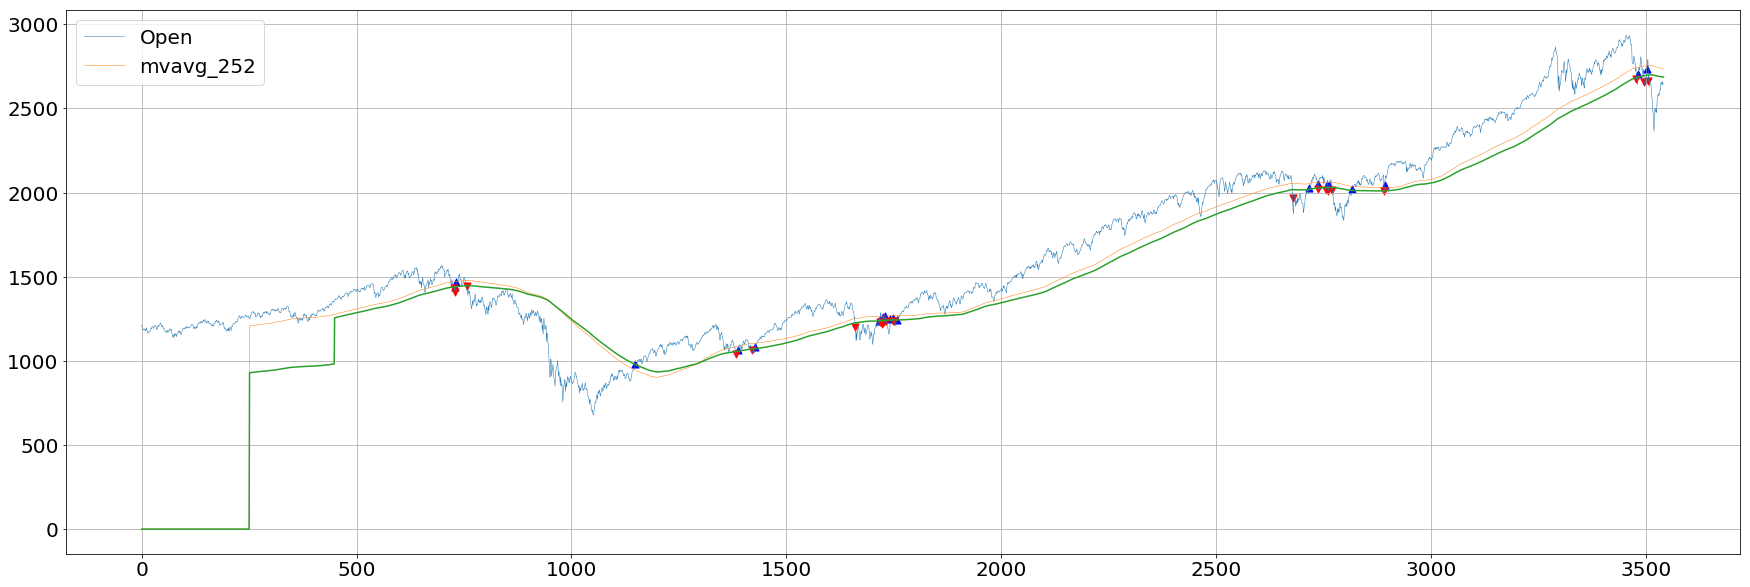

In [41]:
comparen(gspc_test)
visualizen(gspc_test)